In [6]:
conda create -n tfenv python =3.8


Note: you may need to restart the kernel to use updated packages.



InvalidMatchSpec: Invalid spec '=3.8': Invalid spec '=3.8': no package name found in '=3.8'



In [2]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.utils import Sequence 
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2D, ZeroPadding2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping,ReduceLROnPlateau #Import callback functions

ModuleNotFoundError: No module named 'cv2'

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
data=r'C:\Users\afrit\OneDrive\Documents\2. Image Forgery Detection Using Deep Learning With Image Processing\2. Image Forgery Detection Using Deep Learning With Image Processing\Source Code\dataset\Train'

In [4]:
batch_size = 32
img_height = 224
img_width = 224

In [5]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(zoom_range=0.15,width_shift_range=0.2,shear_range=0.15)
test_datagen = ImageDataGenerator()
#Setting train/test split

train = train_datagen.flow_from_directory(data, target_size=(img_height, img_width),
                                                     class_mode="categorical", batch_size=batch_size, subset="training")
test = test_datagen.flow_from_directory(data, target_size=(img_height, img_width),
                                                    class_mode="categorical", batch_size=batch_size, shuffle=False)

Found 2041 images belonging to 2 classes.
Found 2041 images belonging to 2 classes.


In [6]:
classess = train.num_classes
classess

2

In [7]:
Mobilenet = MobileNet(weights='imagenet', include_top = False, input_shape = (224,224,3))

In [8]:
for i in Mobilenet.layers:
    i.trainable = False

In [9]:
def main_model(tl_model,classess):
    m_model = tl_model.output
    m_model = GlobalAveragePooling2D()(m_model)
    m_model = Dense(1024,activation='relu')(m_model)
    m_model = Dense(1024,activation='relu')(m_model)
    m_model = Dense(512,activation='relu')(m_model)
    m_model = Dense(classess,activation = 'softmax')(m_model)
    return m_model

In [10]:
combining_model = main_model(Mobilenet,classess)

In [11]:
model = Model(inputs=Mobilenet.input, outputs=combining_model)

In [12]:
model.compile(optimizer="Adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                      

                                                                 
 conv_pw_8_bn (BatchNormaliz  (None, 14, 14, 512)      2048      
 ation)                                                          
                                                                 
 conv_pw_8_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_dw_9 (DepthwiseConv2D)  (None, 14, 14, 512)      4608      
                                                                 
 conv_dw_9_bn (BatchNormaliz  (None, 14, 14, 512)      2048      
 ation)                                                          
                                                                 
 conv_dw_9_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_pw_9 (Conv2D)          (None, 14, 14, 512)       262144    
                                                                 
 conv_pw_9

In [13]:
earlystop=EarlyStopping(patience=10) #Monitor the performance. If it dips, then stop training
learning_rate_reduce=ReduceLROnPlateau(monitor="val_accuracy",min_lr=0.001) #Change learning rate if not performing good enough
callbacks=[earlystop,learning_rate_reduce]

In [14]:
history = model.fit(train, validation_data=test, epochs=1)

64/64 [==============================] - 745s 12s/step - loss: 0.9045 - accuracy: 0.5066 - val_loss: 0.6821 - val_accuracy: 0.5321


In [15]:
model.save("mobilent_project.h5")

In [16]:
test_score = model.evaluate(test)

64/64 [==============================] - 433s 7s/step - loss: 0.6821 - accuracy: 0.5321


In [17]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools 


target_names = []
for key in train.class_indices:
    target_names.append(key)

In [18]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    plt.figure(figsize=(10,10))

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

64/64 [==============================] - 452s 7s/step
Confusion Matrix
Confusion matrix, without normalization


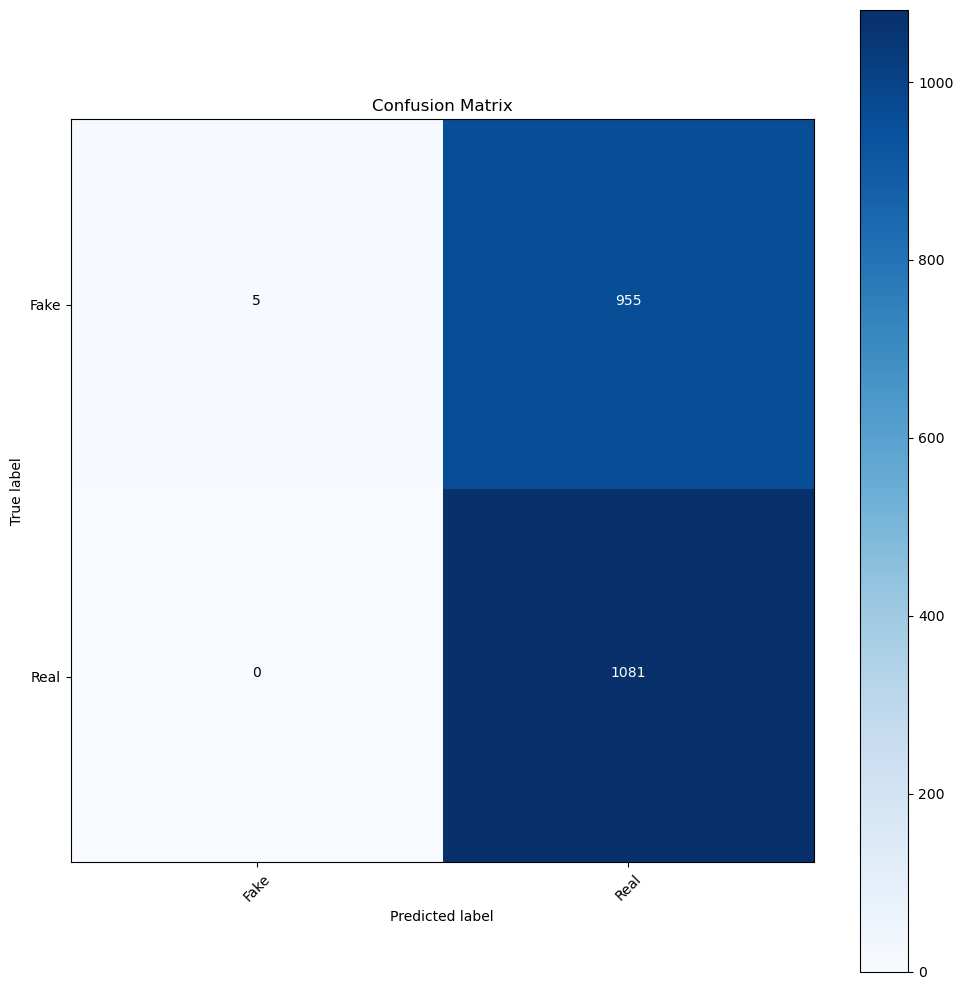

In [19]:
#Confution Matrix and Classification Report
Y_pred = model.predict(test)
y_pred = np.argmax(Y_pred, axis=-1)
print('Confusion Matrix') 
cm=confusion_matrix(test.classes, y_pred)

plot_confusion_matrix(cm, target_names, title='Confusion Matrix')


In [20]:
print('Classification Report')
print(classification_report(test.classes, y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

        Fake       1.00      0.01      0.01       960
        Real       0.53      1.00      0.69      1081

    accuracy                           0.53      2041
   macro avg       0.77      0.50      0.35      2041
weighted avg       0.75      0.53      0.37      2041



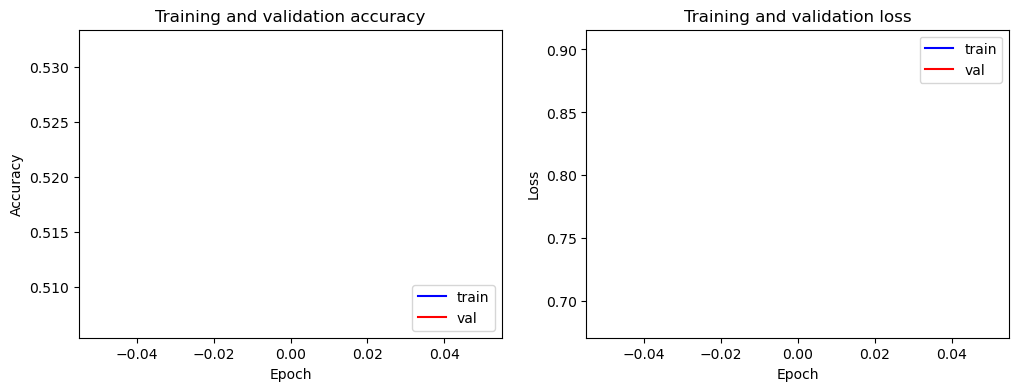

In [21]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(train_accuracy))
plt.figure(figsize=(12,4))

# Plotting the accuracy
plt.subplot(1,2,1)
plt.plot(epochs, train_accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='lower right')

# Plotting the loss
plt.subplot(1,2,2)
plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'val'], loc='upper right')

plt.show()

In [22]:
labels = train.class_indices
final_labels = {v: k for k, v in labels.items()}
final_labels

{0: 'Fake', 1: 'Real'}

In [23]:
from tensorflow.keras.models import load_model
import ast
from tensorflow.keras.preprocessing import image

In [24]:
def predict_image(imgname, from_test_dir):
    test_image = image.load_img(imgname, target_size = (224, 224))

    plt.imshow(test_image)
    plt.show()

    test_image = np.asarray(test_image)
    test_image = np.expand_dims(test_image, axis=0)
    result = model.predict(test_image)

    result_dict = dict()
    for key in list(final_labels.keys()):
        result_dict[final_labels[key]] = result[0][key]
    sorted_results = {k: v for k, v in sorted(result_dict.items(), key=lambda item: item[1], reverse=True)}

    if not from_test_dir:
        print('=' * 50)
        for label in sorted_results.keys():
            print("{}: {}%".format(label, sorted_results[label] * 100))

    final_result = dict()
    final_result[list(sorted_results.keys())[0]] = sorted_results[list(sorted_results.keys())[0]] * 100

    return final_result




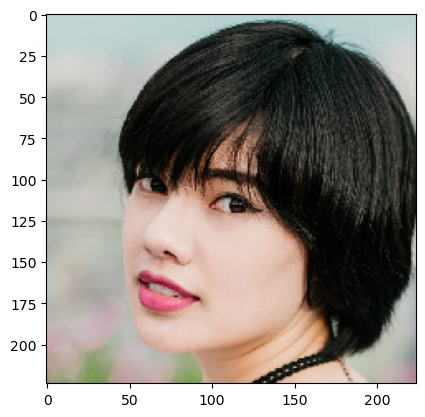

1/1 [==============================] - 3s 3s/step
Real: 55.939823389053345%
Fake: 44.06017363071442%
Final Result:  {'Real': 55.939823389053345}


In [25]:
#print('=' * 50)
final_result1 = predict_image(r"C:\Users\afrit\OneDrive\Documents\2. Image Forgery Detection Using Deep Learning With Image Processing\2. Image Forgery Detection Using Deep Learning With Image Processing\Source Code\dataset\Train", False)
print("Final Result: ", final_result1)




In [1]:
final_result2 = predict_image(r"C:\Users\afrit\OneDrive\Documents\2. Image Forgery Detection Using Deep Learning With Image Processing\2. Image Forgery Detection Using Deep Learning With Image Processing\Source Code\dataset\Train", False)
print("Final Result: ", final_result2)


NameError: name 'predict_image' is not defined

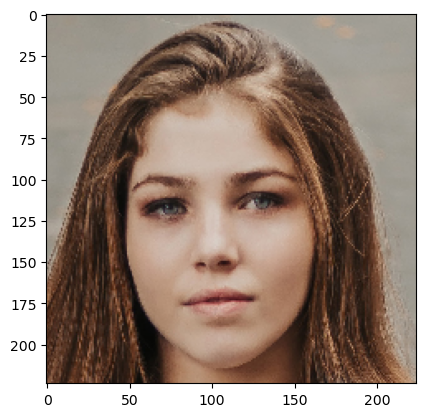

1/1 [==============================] - 0s 248ms/step
Real: 53.86961102485657%
Fake: 46.130383014678955%
Final Result:  {'Real': 53.86961102485657}


In [27]:
final_result3 = predict_image(r'R:\project\Image forgery detection using deep learning by python\Source Code\dataset\Train\Real\real_00107.jpg', False)
print("Final Result: ", final_result3)